## Notebook 3 — Model Estimation and Comparison (Econometric + ML Models)

This notebook extends the feature-engineered dataset prepared in **Notebook 2** to estimate, evaluate, and compare **econometric** and **machine learning** models for forecasting hotel demand across EU countries (2015–2025).
It provides both traditional time-series baselines (ARIMAX, SARIMAX) and modern predictive frameworks (XGBoost, LightGBM), ensuring methodological rigor and cross-model comparability.

The notebook is structured in two complementary parts:

- **Part 1 — Econometric Models:** Focuses on ARIMAX and SARIMAX specifications estimated on full historical data to capture macroeconomic and seasonal dynamics.

- **Part 2 — Machine Learning Models:** Implements time-split training for XGBoost and LightGBM models to assess generalization performance and prepare interpretable outputs for SHAP-based analysis.

---

### **Structure Overview**

0. Environment Setup  
1. Load Dataset  
**Part 1 — Econometric Modeling (ARIMAX, SARIMAX)**
2. Naive Forecast (Last Month = Prediction)
3. ARIMAX Forecast (Per Region)
4. SARIMAX Forecast (Per Region)
5. Comparison: ARIMAX vs SARIMAX (Top 5 EU Countries)
6. Model Performance Check: ARIMAX vs SARIMAX  
**Part 2 — Machine Learning Models (XGBoost + LightGBM)**
7. Data Splitting
8.1 Machine Learning Forecast – XGBoost
8.2 Machine Learning Forecast – LightGBM
9. Comparison: XGBoost vs LightGBM (Top 5 EU Countries)
10. Machine Learning Models Evaluation and Save Predictions
11. Save Feature Matrix for SHAP Analysis
12. Save Transformed SHAP Matrix (For XGB / LGBM)
13. Summary and Handoff to Notebook 4  

---

**Input**  
📁 `../data/processed/hotel_features.csv`  

**Output:**  
📁 `../data/processed/hotel_predictions.csv`  
📁 `../outputs/models/arimax/arimax_<region>.pkl`  
📁 `../outputs/models/sarimax/sarimax_<region>.pkl`  
📁 `../outputs/models/pipe_xgb.pkl, pipe_lgbm.pkl`  
📁 `../outputs/models/lgbm/lgbm_<region>.pkl`  
📁 `../outputs/reports/model_evaluation_summary.csv`  

**Next Notebook:**  
➡️ *Notebook 4 – Explainability and Economic Interpretation (SHAP + Panel Regression)*

---

### 0. Environmental Setup

In [1]:
# %% -----------------------------------------------
# STEP 0 — ENVIRONMENT SETUP
# -----------------------------------------------
# Import required libraries, set visualization style, and define directory paths.

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import joblib
import json
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os
import sys
from contextlib import contextmanager

import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

BASE_DIR = Path("..")
DATA_PROCESSED = BASE_DIR / "data" / "processed"
OUTPUTS = BASE_DIR / "outputs"
FIGURES = OUTPUTS / "figures"
MODELS = OUTPUTS / "models"
MODELS_ARIMAX = MODELS / "arimax"
MODELS_SARIMAX = MODELS / "sarimax"
REPORTS = OUTPUTS / "reports"

for path in [DATA_PROCESSED, FIGURES, MODELS, MODELS_ARIMAX, MODELS_SARIMAX, REPORTS]:
    path.mkdir(parents=True, exist_ok=True)

print("✅ Environment setup complete.")

✅ Environment setup complete.


### 1. Load Dataset

In [2]:
# %% -----------------------------------------------
# STEP 1 — LOAD FEATURE-ENGINEERED DATASET
# -----------------------------------------------
# Load the cleaned hotel dataset produced in Notebook 2.

FEATURE_PATH = DATA_PROCESSED / "hotel_features.csv"

df = pd.read_csv(FEATURE_PATH, parse_dates=["month"])
df = df.sort_values(["region", "month"]).reset_index(drop=True)
print(f"[INFO] Loaded dataset with shape: {df.shape}")

target = "log_nights_spent"

# --- Identify exogenous variables automatically ---
exog_vars = [
    c for c in df.columns
    if c.endswith(("_lag1", "_lag2", "_lag3", "_mom"))
    and not c.startswith("log_nights_spent")
]

print(f"[INFO] Using {len(exog_vars)} exogenous variables: {exog_vars[:6]} ...")

[INFO] Loaded dataset with shape: (3328, 30)
[INFO] Using 20 exogenous variables: ['log_gdp_lag1', 'log_gdp_lag2', 'log_gdp_lag3', 'unemployment_rate_lag1', 'unemployment_rate_lag2', 'unemployment_rate_lag3'] ...


---

### **Part 1 — Econometric Modeling (ARIMAX, SARIMAX)**

### 2. Naive Forecast (Last Month = Prediction)

In [3]:
# %% -----------------------------------------------
# STEP 2 — NAIVE FORECAST (LAST MONTH = PREDICTION)
# -----------------------------------------------
# Baseline: use previous month's observed log_nights_spent as forecast.

df = df.sort_values(["region", "month"]).copy()
df["yhat_naive"] = df.groupby("region")[target].shift(1)

# Optional check that it aligns with split boundaries
print("[INFO] Added naive baseline (lag-1). Example tail:")
display(df.groupby("region").tail(3)[["region", "month", target, "yhat_naive"]].head(10))

[INFO] Added naive baseline (lag-1). Example tail:


,region,month,log_nights_spent,yhat_naive
125,AT,2025-06-30,14.698787,14.555365
126,AT,2025-07-31,14.821111,14.698787
127,AT,2025-08-31,14.942146,14.821111
253,BE,2025-06-30,13.557848,13.561620
254,BE,2025-07-31,13.634188,13.557848
255,BE,2025-08-31,13.618875,13.634188
381,BG,2025-06-30,13.831692,13.469083
382,BG,2025-07-31,14.341255,13.831692
383,BG,2025-08-31,14.383078,14.341255
509,CY,2025-06-30,11.762392,11.225910


### 3. ARIMAX Forecast (Per Region)

In [4]:
# %% ===============================================================
# STEP 3 — ARIMAX FORECAST (PER REGION)
# ===============================================================
# Purpose:
#   Fit non-seasonal ARIMAX models per region using key macroeconomic variables.
#   Generate in-sample fitted values (after warm-up) and merge results.
# Outputs:
#   - outputs/models/arimax/arimax_<region>.pkl
#   - data/processed/hotel_predictions.csv (merged horizontally)
# ===============================================================

np.random.seed(42)
preds_arimax = []
target = "log_nights_spent"

# --- Define classical macro exogenous variables (econometric baseline) ---
arimax_exog = ["log_gdp", "unemployment_rate", "turnover_index", "weighted_stringency_index"]

df = df.sort_values(["region", "month"]).copy()
df["month"] = pd.to_datetime(df["month"])

print(f"[INFO] Starting ARIMAX modeling for {df['region'].nunique()} regions.")
print(f"[INFO] Using {len(arimax_exog)} exogenous variables: {arimax_exog}")

# --- Ensure model directory exists ---
MODELS_ARIMAX.mkdir(parents=True, exist_ok=True)

# --- Loop per region ---
for region, dfc in tqdm(df.groupby("region"), desc="Fitting ARIMAX by region"):
    dfc = dfc.sort_values("month").dropna(subset=[target]).set_index("month")

    # Ensure exogenous variables are valid
    valid_exog = [c for c in arimax_exog if c in dfc and dfc[c].notna().sum() > 24]
    if len(valid_exog) < len(arimax_exog) or len(dfc) < 36:
        continue

    dfc[valid_exog] = dfc[valid_exog].ffill().bfill()

    try:
        # --- Fit model (non-seasonal ARIMAX) ---
        model = SARIMAX(
            dfc[target],
            exog=dfc[valid_exog],
            order=(1, 0, 1),
            enforce_stationarity=True,
            enforce_invertibility=True
        ).fit(disp=False, maxiter=500)

        # --- Skip first 12 months (warm-up) ---
        warmup = min(12, max(0, len(dfc) - 1))
        start_idx = dfc.index[warmup] if len(dfc) > warmup else dfc.index[0]

        dfc["yhat_arimax"] = model.get_prediction(
            start=start_idx,
            end=dfc.index[-1],
            exog=dfc.loc[start_idx:, valid_exog]
        ).predicted_mean

        preds_arimax.append(dfc.reset_index()[["region", "month", "yhat_arimax"]])

        # --- Save model ---
        model_path = MODELS_ARIMAX / f"arimax_{region}.pkl"
        joblib.dump(model, model_path)
        print(f"[MODEL SAVED] {model_path.name}")

    except Exception as e:
        print(f"[WARN] {region}: {e}")

# --- Merge predictions and save ---
if preds_arimax:
    arim = pd.concat(preds_arimax, ignore_index=True).drop_duplicates(subset=["region", "month"])
    arim["month"] = pd.to_datetime(arim["month"])
    arim["region"] = arim["region"].astype(str)

    df = df.drop(columns=["yhat_arimax"], errors="ignore").merge(
        arim, on=["region", "month"], how="left", validate="m:1"
    )

    out_path = DATA_PROCESSED / "hotel_predictions.csv"
    df.to_csv(out_path, index=False)
    print(f"✅ ARIMAX forecasts saved to {out_path} — {df.shape[0]} rows total.")
else:
    print("⚠️ No ARIMAX results generated.")

# --- Optional verification ---
arimax_files = list(MODELS_ARIMAX.glob("arimax_*.pkl"))
print(f"[INFO] ARIMAX models saved: {len(arimax_files)} → Example: {arimax_files[0].name if arimax_files else 'None'}")

[INFO] Starting ARIMAX modeling for 26 regions.
[INFO] Using 4 exogenous variables: ['log_gdp', 'unemployment_rate', 'turnover_index', 'weighted_stringency_index']


Fitting ARIMAX by region:  12%|█▏        | 3/26 [00:00<00:02,  8.12it/s]

[MODEL SAVED] arimax_AT.pkl
[MODEL SAVED] arimax_BE.pkl
[MODEL SAVED] arimax_BG.pkl


Fitting ARIMAX by region:  15%|█▌        | 4/26 [00:00<00:02,  7.78it/s]

[MODEL SAVED] arimax_CY.pkl
[MODEL SAVED] arimax_CZ.pkl


Fitting ARIMAX by region:  31%|███       | 8/26 [00:00<00:01,  9.15it/s]

[MODEL SAVED] arimax_DE.pkl
[MODEL SAVED] arimax_DK.pkl
[MODEL SAVED] arimax_EE.pkl
[MODEL SAVED] arimax_ES.pkl


Fitting ARIMAX by region:  42%|████▏     | 11/26 [00:01<00:01, 11.58it/s]

[MODEL SAVED] arimax_FI.pkl
[MODEL SAVED] arimax_FR.pkl
[MODEL SAVED] arimax_HR.pkl


Fitting ARIMAX by region:  50%|█████     | 13/26 [00:01<00:01, 10.95it/s]

[MODEL SAVED] arimax_HU.pkl
[MODEL SAVED] arimax_IE.pkl


Fitting ARIMAX by region:  58%|█████▊    | 15/26 [00:01<00:01, 10.57it/s]

[MODEL SAVED] arimax_IT.pkl
[MODEL SAVED] arimax_LT.pkl


Fitting ARIMAX by region:  73%|███████▎  | 19/26 [00:01<00:00, 11.52it/s]

[MODEL SAVED] arimax_LU.pkl
[MODEL SAVED] arimax_LV.pkl
[MODEL SAVED] arimax_MT.pkl


Fitting ARIMAX by region:  81%|████████  | 21/26 [00:02<00:00, 10.56it/s]

[MODEL SAVED] arimax_NL.pkl
[MODEL SAVED] arimax_PL.pkl


Fitting ARIMAX by region:  88%|████████▊ | 23/26 [00:02<00:00,  8.54it/s]

[MODEL SAVED] arimax_PT.pkl
[MODEL SAVED] arimax_RO.pkl


Fitting ARIMAX by region: 100%|██████████| 26/26 [00:02<00:00,  9.73it/s]

[MODEL SAVED] arimax_SE.pkl
[MODEL SAVED] arimax_SI.pkl
[MODEL SAVED] arimax_SK.pkl
✅ ARIMAX forecasts saved to ../data/processed/hotel_predictions.csv — 3328 rows total.
[INFO] ARIMAX models saved: 26 → Example: arimax_HR.pkl


### 4. SARIMAX Forecast (Per Region)

In [5]:
# %% ===============================================================
# STEP 4 — SARIMAX FORECAST (PER REGION)
# ===============================================================
# Purpose:
#   Fit seasonal ARIMAX (SARIMAX) models per region using lagged and MoM features.
#   Generate in-sample fitted values (after warm-up) and merge results.
# Outputs:
#   - outputs/models/sarimax/sarimax_<region>.pkl
#   - data/processed/hotel_predictions.csv (merged horizontally)
# ===============================================================

np.random.seed(42)
preds_sarimax = []
target = "log_nights_spent"

df = df.sort_values(["region", "month"]).copy()
df["month"] = pd.to_datetime(df["month"])

print(f"[INFO] Starting SARIMAX modeling for {df['region'].nunique()} regions.")
print(f"[INFO] Using {len(exog_vars)} dynamic exogenous variables.")

# --- Ensure model directory exists ---
MODELS_SARIMAX.mkdir(parents=True, exist_ok=True)

# --- Loop per region ---
for region, dfc in tqdm(df.groupby("region"), desc="Fitting SARIMAX by region"):
    dfc = dfc.sort_values("month").dropna(subset=[target]).set_index("month")

    valid_exog = [c for c in exog_vars if c in dfc and dfc[c].notna().sum() > 24]
    if len(valid_exog) == 0 or len(dfc) < 36:
        continue

    dfc[valid_exog] = dfc[valid_exog].ffill().bfill()

    try:
        # --- Fit model (seasonal SARIMAX) ---
        model = SARIMAX(
            dfc[target],
            exog=dfc[valid_exog],
            order=(1, 0, 1),
            seasonal_order=(1, 1, 1, 12),
            enforce_stationarity=True,
            enforce_invertibility=True
        ).fit(disp=False, maxiter=500)

        # --- Skip first 12 months (warm-up) ---
        warmup = min(12, max(0, len(dfc) - 1))
        start_idx = dfc.index[warmup] if len(dfc) > warmup else dfc.index[0]

        dfc["yhat_sarimax"] = model.get_prediction(
            start=start_idx,
            end=dfc.index[-1],
            exog=dfc.loc[start_idx:, valid_exog]
        ).predicted_mean

        preds_sarimax.append(dfc.reset_index()[["region", "month", "yhat_sarimax"]])

        # --- Save model ---
        model_path = MODELS_SARIMAX / f"sarimax_{region}.pkl"
        joblib.dump(model, model_path)
        print(f"[MODEL SAVED] {model_path.name}")

    except Exception as e:
        print(f"[WARN] {region}: {e}")

# --- Merge predictions and save ---
if preds_sarimax:
    sari = pd.concat(preds_sarimax, ignore_index=True).drop_duplicates(subset=["region", "month"])
    sari["month"] = pd.to_datetime(sari["month"])
    sari["region"] = sari["region"].astype(str)

    df = df.drop(columns=["yhat_sarimax"], errors="ignore").merge(
        sari, on=["region", "month"], how="left", validate="m:1"
    )

    out_path = DATA_PROCESSED / "hotel_predictions.csv"
    df.to_csv(out_path, index=False)
    print(f"✅ SARIMAX forecasts saved to {out_path} — {df.shape[0]} rows total.")
else:
    print("⚠️ No SARIMAX results generated.")

# --- Optional verification ---
sarimax_files = list(MODELS_SARIMAX.glob("sarimax_*.pkl"))
print(f"[INFO] SARIMAX models saved: {len(sarimax_files)} → Example: {sarimax_files[0].name if sarimax_files else 'None'}")

[INFO] Starting SARIMAX modeling for 26 regions.
[INFO] Using 20 dynamic exogenous variables.


Fitting SARIMAX by region:   4%|▍         | 1/26 [00:11<04:43, 11.34s/it]

[MODEL SAVED] sarimax_AT.pkl


Fitting SARIMAX by region:   8%|▊         | 2/26 [00:22<04:32, 11.36s/it]

[MODEL SAVED] sarimax_BE.pkl


Fitting SARIMAX by region:  12%|█▏        | 3/26 [00:34<04:20, 11.34s/it]

[MODEL SAVED] sarimax_BG.pkl


Fitting SARIMAX by region:  15%|█▌        | 4/26 [00:45<04:12, 11.48s/it]

[MODEL SAVED] sarimax_CY.pkl


Fitting SARIMAX by region:  19%|█▉        | 5/26 [00:56<03:58, 11.36s/it]

[MODEL SAVED] sarimax_CZ.pkl


Fitting SARIMAX by region:  23%|██▎       | 6/26 [01:07<03:44, 11.22s/it]

[MODEL SAVED] sarimax_DE.pkl


Fitting SARIMAX by region:  27%|██▋       | 7/26 [01:16<03:17, 10.38s/it]

[MODEL SAVED] sarimax_DK.pkl


Fitting SARIMAX by region:  31%|███       | 8/26 [01:27<03:09, 10.54s/it]

[MODEL SAVED] sarimax_EE.pkl


Fitting SARIMAX by region:  35%|███▍      | 9/26 [01:38<03:01, 10.67s/it]

[MODEL SAVED] sarimax_ES.pkl


Fitting SARIMAX by region:  38%|███▊      | 10/26 [01:49<02:53, 10.84s/it]

[MODEL SAVED] sarimax_FI.pkl


Fitting SARIMAX by region:  42%|████▏     | 11/26 [02:00<02:44, 11.00s/it]

[MODEL SAVED] sarimax_FR.pkl


Fitting SARIMAX by region:  46%|████▌     | 12/26 [02:11<02:33, 10.94s/it]

[MODEL SAVED] sarimax_HR.pkl


Fitting SARIMAX by region:  50%|█████     | 13/26 [02:21<02:19, 10.71s/it]

[MODEL SAVED] sarimax_HU.pkl


Fitting SARIMAX by region:  54%|█████▍    | 14/26 [02:31<02:06, 10.51s/it]

[MODEL SAVED] sarimax_IE.pkl


Fitting SARIMAX by region:  58%|█████▊    | 15/26 [02:42<01:56, 10.63s/it]

[MODEL SAVED] sarimax_IT.pkl


Fitting SARIMAX by region:  62%|██████▏   | 16/26 [02:53<01:47, 10.75s/it]

[MODEL SAVED] sarimax_LT.pkl


Fitting SARIMAX by region:  65%|██████▌   | 17/26 [03:03<01:33, 10.44s/it]

[MODEL SAVED] sarimax_LU.pkl


Fitting SARIMAX by region:  69%|██████▉   | 18/26 [03:04<01:01,  7.73s/it]

[MODEL SAVED] sarimax_LV.pkl


Fitting SARIMAX by region:  73%|███████▎  | 19/26 [03:15<01:00,  8.71s/it]

[MODEL SAVED] sarimax_MT.pkl


Fitting SARIMAX by region:  77%|███████▋  | 20/26 [03:27<00:56,  9.42s/it]

[MODEL SAVED] sarimax_NL.pkl


Fitting SARIMAX by region:  81%|████████  | 21/26 [03:38<00:49,  9.89s/it]

[MODEL SAVED] sarimax_PL.pkl


Fitting SARIMAX by region:  85%|████████▍ | 22/26 [03:49<00:40, 10.22s/it]

[MODEL SAVED] sarimax_PT.pkl


Fitting SARIMAX by region:  88%|████████▊ | 23/26 [03:59<00:30, 10.17s/it]

[MODEL SAVED] sarimax_RO.pkl


Fitting SARIMAX by region:  92%|█████████▏| 24/26 [04:10<00:20, 10.47s/it]

[MODEL SAVED] sarimax_SE.pkl


Fitting SARIMAX by region:  96%|█████████▌| 25/26 [04:20<00:10, 10.35s/it]

[MODEL SAVED] sarimax_SI.pkl


Fitting SARIMAX by region: 100%|██████████| 26/26 [04:30<00:00, 10.41s/it]

[MODEL SAVED] sarimax_SK.pkl
✅ SARIMAX forecasts saved to ../data/processed/hotel_predictions.csv — 3328 rows total.
[INFO] SARIMAX models saved: 26 → Example: sarimax_AT.pkl


### 5. Comparison: ARIMAX vs SARIMAX (Top 5 EU Countries)

[INFO] Added ARIMAX & SARIMAX predictions from hotel_predictions.csv
[INFO] Plotting ARIMAX vs SARIMAX for: ['DE', 'FR', 'IT', 'ES', 'PL']


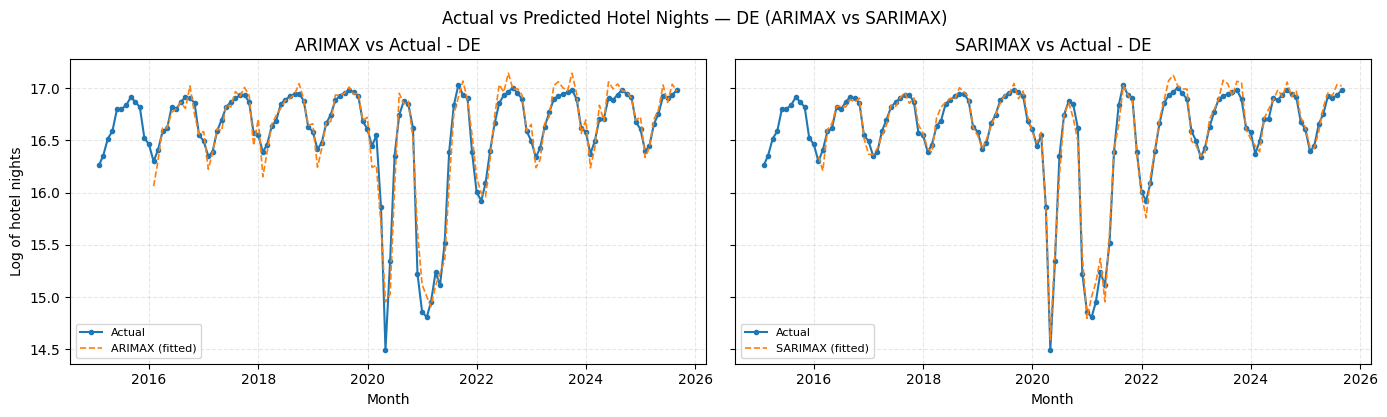

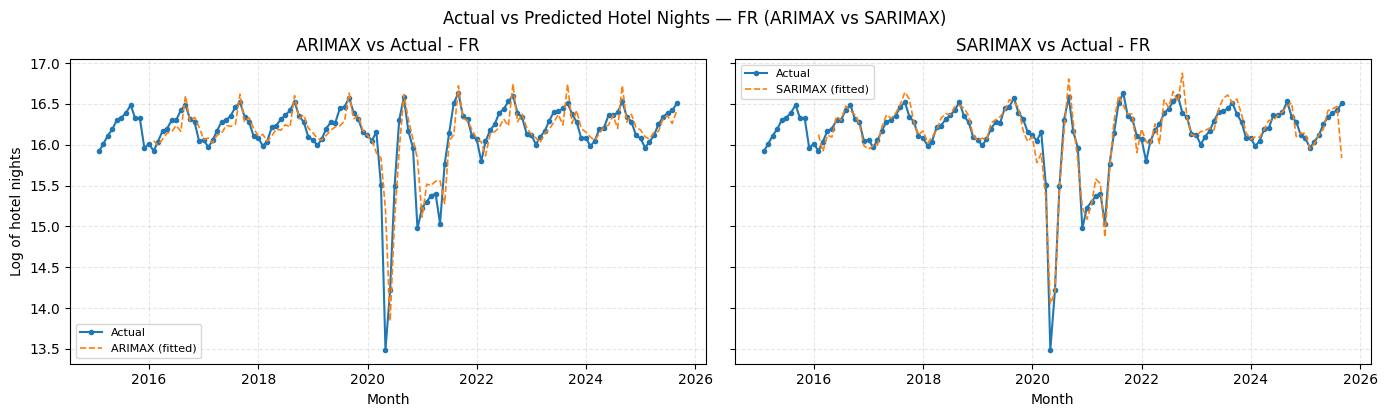

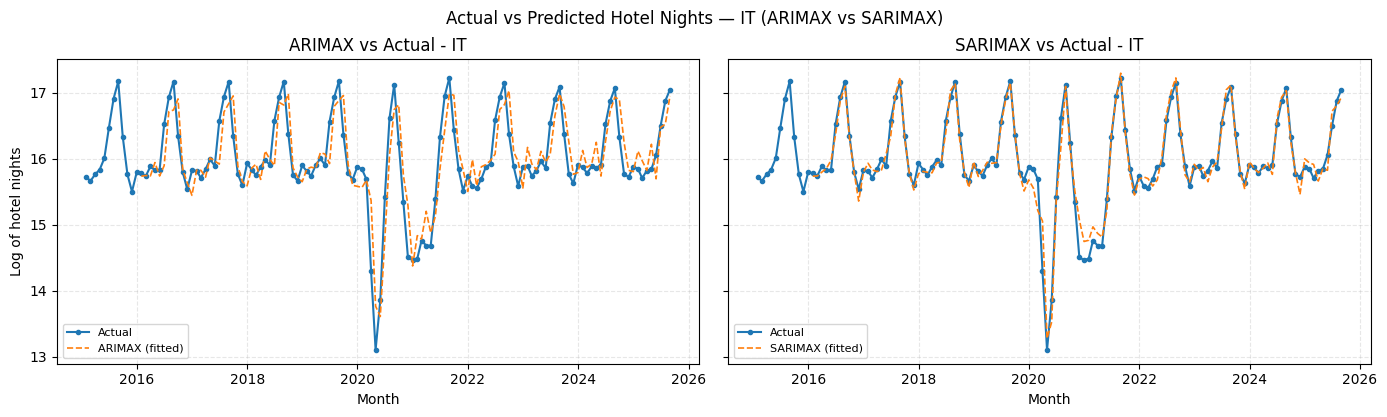

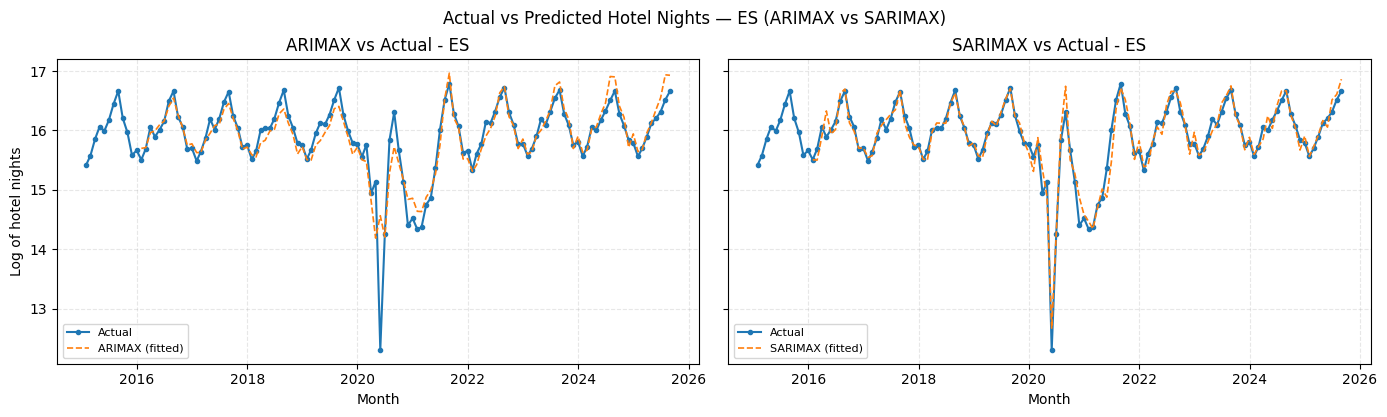

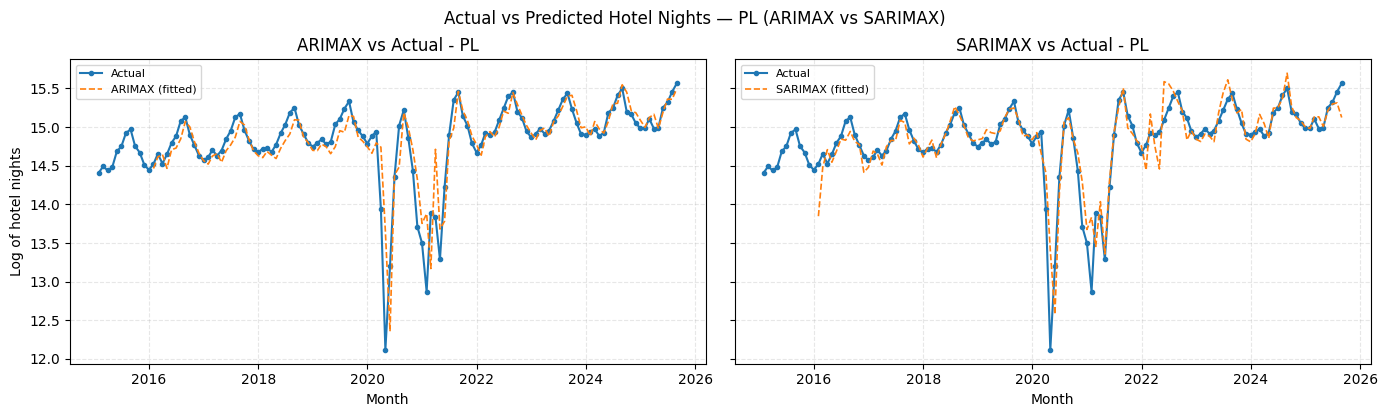

In [6]:
# %% -----------------------------------------------
# STEP 5 — COMPARISON: ARIMAX vs SARIMAX (TOP 5 EU COUNTRIES)
# -----------------------------------------------

# --- 1. Merge ARIMAX results from Notebook 2 ---

PRED_PATH = DATA_PROCESSED / "hotel_predictions.csv"

if PRED_PATH.exists():
    preds = pd.read_csv(PRED_PATH, parse_dates=["month"])
    preds = preds[["region", "month", "yhat_arimax", "yhat_sarimax"]].drop_duplicates(subset=["region", "month"])
    df = df.drop(columns=["yhat_arimax", "yhat_sarimax"], errors="ignore")
    df = df.merge(preds, on=["region", "month"], how="left", validate="m:1")
    print(f"[INFO] Added ARIMAX & SARIMAX predictions from {PRED_PATH.name}")
else:
    print("[WARN] hotel_predictions.csv not found — check path.")

# --- 2. Econometric Comparison — ARIMAX vs SARIMAX (Top 5 EU Countries) ---

# Use plain matplotlib style (disable seaborn look)
plt.style.use("default")

# Select top 5 by average demand
top_regions = (
    df.groupby("region")["log_nights_spent"]
    .mean()
    .nlargest(5)
    .index.tolist()
)
print(f"[INFO] Plotting ARIMAX vs SARIMAX for: {top_regions}")

for country in top_regions:
    subset = df.query("region == @country").sort_values("month")
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    # --- Left: ARIMAX ---
    axes[0].plot(
        subset["month"], subset["log_nights_spent"],
        label="Actual", marker="o", markersize=3, lw=1.5
    )
    if "yhat_arimax" in subset.columns:
        axes[0].plot(
            subset["month"], subset["yhat_arimax"],
            label="ARIMAX (fitted)", linestyle="--", lw=1.2
        )
    axes[0].set_title(f"ARIMAX vs Actual - {country}")
    axes[0].set_xlabel("Month")
    axes[0].set_ylabel("Log of hotel nights")
    axes[0].legend(fontsize=8)
    axes[0].grid(alpha=0.3, linestyle="--")

    # --- Right: SARIMAX ---
    axes[1].plot(
        subset["month"], subset["log_nights_spent"],
        label="Actual", marker="o", markersize=3, lw=1.5
    )
    if "yhat_sarimax" in subset.columns:
        axes[1].plot(
            subset["month"], subset["yhat_sarimax"],
            label="SARIMAX (fitted)", linestyle="--", lw=1.2
        )
    axes[1].set_title(f"SARIMAX vs Actual - {country}")
    axes[1].set_xlabel("Month")
    axes[1].legend(fontsize=8)
    axes[1].grid(alpha=0.3, linestyle="--")

    plt.tight_layout()
    plt.suptitle(
        f"Actual vs Predicted Hotel Nights — {country} (ARIMAX vs SARIMAX)",
        fontsize=12, fontweight="normal", y=1.03
    )
    plt.show()

### 6. Model Performance Check: ARIMAX vs SARIMAX

In [7]:
# %% -----------------------------------------------
# STEP 6 — MODEL PERFORMANCE CHECK (ARIMAX vs SARIMAX)
# -----------------------------------------------

def rmse(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

# Compute per-region metrics
res_econometric = (
    df.dropna(subset=["yhat_arimax", "yhat_sarimax", "log_nights_spent"])
      .groupby("region", group_keys=False)
      .apply(lambda d: pd.Series({
          "MAE_ARIMAX": mean_absolute_error(d["log_nights_spent"], d["yhat_arimax"]),
          "RMSE_ARIMAX": rmse(d["log_nights_spent"], d["yhat_arimax"]),
          "MAE_SARIMAX": mean_absolute_error(d["log_nights_spent"], d["yhat_sarimax"]),
          "RMSE_SARIMAX": rmse(d["log_nights_spent"], d["yhat_sarimax"]),
      }))
      .reset_index()
)

# Determine which model performs better
res_econometric["Better_Model"] = np.where(
    res_econometric["RMSE_ARIMAX"] < res_econometric["RMSE_SARIMAX"],
    "ARIMAX", "SARIMAX"
)

display(res_econometric.round(4))

# --- Compute and display averages ---
mean_rmse_arimax = res_econometric["RMSE_ARIMAX"].mean()
mean_rmse_sarimax = res_econometric["RMSE_SARIMAX"].mean()
mean_mae_arimax = res_econometric["MAE_ARIMAX"].mean()
mean_mae_sarimax = res_econometric["MAE_SARIMAX"].mean()

rmse_improvement = 100 * (mean_rmse_arimax - mean_rmse_sarimax) / mean_rmse_arimax
mae_improvement = 100 * (mean_mae_arimax - mean_mae_sarimax) / mean_mae_arimax

print("📊 Overall ARIMAX vs SARIMAX comparison (all regions):\n")
print(f"Mean RMSE — ARIMAX: {mean_rmse_arimax:.4f}, SARIMAX: {mean_rmse_sarimax:.4f} → Improvement: {rmse_improvement:.1f}%")
print(f"Mean MAE  — ARIMAX: {mean_mae_arimax:.4f}, SARIMAX: {mean_mae_sarimax:.4f} → Improvement: {mae_improvement:.1f}%")

sarimax_wins = (res_econometric["Better_Model"] == "SARIMAX").sum()
total_regions = len(res_econometric)
print(f"\n🏆 SARIMAX performs better in {sarimax_wins}/{total_regions} regions ({100 * sarimax_wins / total_regions:.1f}%).")

,region,MAE_ARIMAX,RMSE_ARIMAX,MAE_SARIMAX,RMSE_SARIMAX,Better_Model
0,AT,0.1876,0.2696,0.1389,0.2093,SARIMAX
1,BE,0.1656,0.2619,0.1322,0.2063,SARIMAX
2,BG,0.1608,0.2380,0.1305,0.1820,SARIMAX
3,CY,0.3532,0.5418,0.2772,0.4135,SARIMAX
4,CZ,0.2217,0.3436,0.1588,0.2156,SARIMAX
5,DE,0.0915,0.1254,0.0574,0.0766,SARIMAX
6,DK,0.1376,0.2074,0.0903,0.1297,SARIMAX
7,EE,0.1447,0.2079,0.0920,0.1226,SARIMAX
8,ES,0.1567,0.2843,0.1104,0.1544,SARIMAX
9,FI,0.1327,0.1880,0.0670,0.0924,SARIMAX


📊 Overall ARIMAX vs SARIMAX comparison (all regions):

Mean RMSE — ARIMAX: 0.3026, SARIMAX: 0.2151 → Improvement: 28.9%
Mean MAE  — ARIMAX: 0.1836, SARIMAX: 0.1473 → Improvement: 19.8%

🏆 SARIMAX performs better in 26/26 regions (100.0%).


---

### **Part 2 — Machine Learning Models (XGBoost + LightGBM)**

### 7. Data Splitting

In [8]:
# %% -----------------------------------------------
# STEP 7 — TRAIN-VALIDATION SPLIT
# -----------------------------------------------
# Split the data into train, valid, and test datasets with proper sorting.

df = df.sort_values(["region", "month"]).reset_index(drop=True)

train = df[df["month"] < "2024-01-01"].copy()
valid = df[(df["month"] >= "2024-01-01") & (df["month"] < "2025-01-01")].copy()
test  = df[df["month"] >= "2025-01-01"].copy()

# Just for clarity, verify region order and counts
print(f"Train: {train.shape}, Valid: {valid.shape}, Test: {test.shape}")
print(f"Regions (train): {train['region'].nunique()}, (valid): {valid['region'].nunique()}, (test): {test['region'].nunique()}")

Train: (2808, 33), Valid: (312, 33), Test: (208, 33)
Regions (train): 26, (valid): 26, (test): 26


### 8.1. Machine Learning Forecast - XGBoost

In [9]:
# %% ===============================================================
# STEP 8.1 — MACHINE LEARNING FORECASTS: XGBOOST (GLOBAL MODEL)
# ===============================================================
# Purpose:
#   Train a single XGBoost model across all regions using lagged + MoM features.
# Outputs:
#   - df['yhat_xgb']
#   - outputs/models/pipe_xgb.pkl
# ===============================================================

np.random.seed(42)

# --- Feature setup ---
cat_cols = ["region"]
num_cols = [c for c in df.columns if c.endswith(("_lag1", "_lag2", "_lag3", "_mom"))]
num_cols = [c for c in num_cols if c in df.columns]  # safety
target = "log_nights_spent"

X_train = train[cat_cols + num_cols].copy()
X_valid = valid[cat_cols + num_cols].copy()
y_train = train[target].values
y_valid = valid[target].values

# --- Preprocessor ---
pre = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ("num", "passthrough", num_cols)
])

print("[INFO] Training global XGBoost model...")

xgb_model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1,
    objective="reg:squarederror"
)

pipe_xgb = Pipeline([
    ("pre", pre),
    ("model", xgb_model)
])

pipe_xgb.fit(X_train, y_train)
valid["yhat_xgb"] = pipe_xgb.predict(X_valid)
df.loc[valid.index, "yhat_xgb"] = valid["yhat_xgb"]

print(f"[INFO] Stored XGBoost predictions: {valid['yhat_xgb'].notna().sum()} rows")

# --- Save global model ---
MODELS.mkdir(parents=True, exist_ok=True)
xgb_model_path = MODELS / "pipe_xgb.pkl"
joblib.dump(pipe_xgb, xgb_model_path)
print(f"💾 XGBoost pipeline saved → {xgb_model_path.resolve()}")

[INFO] Training global XGBoost model...
[INFO] Stored XGBoost predictions: 312 rows
💾 XGBoost pipeline saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/outputs/models/pipe_xgb.pkl


### 8.2. Machine Learning Forecast - LightGBM

In [10]:
# %% ===============================================================
# STEP 8.2 — MACHINE LEARNING FORECASTS: LIGHTGBM (REGION MODELS)
# ===============================================================
# Purpose:
#   Train separate LightGBM models per region and store individual .pkl files.
#   Additionally, save one global LightGBM pipeline for SHAP explainability.
# Outputs:
#   - df['yhat_lgbm']
#   - outputs/models/lgbm/lgbm_<region>.pkl
#   - outputs/models/pipe_lgbm.pkl  ← NEW (for Notebook 4)
# ===============================================================

@contextmanager
def suppress_stdout_stderr():
    """Suppress LightGBM training output for cleaner logs."""
    with open(os.devnull, "w") as devnull:
        old_stdout, old_stderr = sys.stdout, sys.stderr
        try:
            sys.stdout, sys.stderr = devnull, devnull
            yield
        finally:
            sys.stdout, sys.stderr = old_stdout, old_stderr

# --- Create LGBM folder ---
MODELS_LGBM = MODELS / "lgbm"
MODELS_LGBM.mkdir(parents=True, exist_ok=True)

print("[INFO] Training region-specific LightGBM models...")

region_preds = []

# ===============================================================
# 🔹 Train per-region LightGBM models
# ===============================================================
for region in df["region"].unique():
    train_r = train[train["region"] == region].copy()
    valid_r = valid[valid["region"] == region].copy()

    if len(train_r) < 24 or len(valid_r) == 0:
        print(f"[WARN] Skipping {region}: insufficient data.")
        continue

    X_train_r = train_r[cat_cols + num_cols]
    X_valid_r = valid_r[cat_cols + num_cols]
    y_train_r = train_r[target].values
    y_valid_r = valid_r[target].values

    lgbm_model = LGBMRegressor(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=-1,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        n_jobs=-1
    )

    pipe_lgbm = Pipeline([
        ("pre", pre),
        ("model", lgbm_model)
    ])

    with suppress_stdout_stderr():
        pipe_lgbm.fit(X_train_r, y_train_r)

    # --- Predict and store validation results ---
    valid_r["yhat_lgbm"] = pipe_lgbm.predict(X_valid_r)
    region_preds.append(valid_r[["region", "month", "yhat_lgbm"]])

    # --- Save model ---
    model_path = MODELS_LGBM / f"lgbm_{region}.pkl"
    joblib.dump(pipe_lgbm, model_path)
    print(f"💾 Saved LightGBM model for {region} → {model_path.name}")

# ===============================================================
# 🔸 Combine predictions
# ===============================================================
if region_preds:
    preds_lgbm = pd.concat(region_preds, ignore_index=True)
    df = df.drop(columns=["yhat_lgbm"], errors="ignore").merge(
        preds_lgbm, on=["region", "month"], how="left"
    )
    print(f"[INFO] Stored region-based LightGBM predictions: {len(preds_lgbm)} rows")

print("✅ All region-specific LightGBM models trained and saved.")

# ===============================================================
# 🧩 Save GLOBAL LightGBM pipeline (for SHAP)
# ===============================================================
# We train one full-sample LightGBM model with the same preprocessing pipeline.
# This is necessary for global feature-importance analysis in Notebook 4.
# ===============================================================

print("\n[INFO] Training global LightGBM pipeline for SHAP explainability...")

# --- Prepare full training data ---
X_train_global = train[cat_cols + num_cols]
y_train_global = train[target].values

lgbm_global = LGBMRegressor(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=-1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    n_jobs=-1
)

pipe_lgbm = Pipeline([
    ("pre", pre),
    ("model", lgbm_global)
])

with suppress_stdout_stderr():
    pipe_lgbm.fit(X_train_global, y_train_global)

PIPE_LGBM_PATH = MODELS / "pipe_lgbm.pkl"
joblib.dump(pipe_lgbm, PIPE_LGBM_PATH)

print(f"✅ Global LightGBM pipeline saved → {PIPE_LGBM_PATH}")
print("🎯 Ready for SHAP analysis in Notebook 4.")


[INFO] Training region-specific LightGBM models...
💾 Saved LightGBM model for AT → lgbm_AT.pkl
💾 Saved LightGBM model for BE → lgbm_BE.pkl
💾 Saved LightGBM model for BG → lgbm_BG.pkl
💾 Saved LightGBM model for CY → lgbm_CY.pkl
💾 Saved LightGBM model for CZ → lgbm_CZ.pkl
💾 Saved LightGBM model for DE → lgbm_DE.pkl
💾 Saved LightGBM model for DK → lgbm_DK.pkl
💾 Saved LightGBM model for EE → lgbm_EE.pkl
💾 Saved LightGBM model for ES → lgbm_ES.pkl
💾 Saved LightGBM model for FI → lgbm_FI.pkl
💾 Saved LightGBM model for FR → lgbm_FR.pkl
💾 Saved LightGBM model for HR → lgbm_HR.pkl
💾 Saved LightGBM model for HU → lgbm_HU.pkl
💾 Saved LightGBM model for IE → lgbm_IE.pkl
💾 Saved LightGBM model for IT → lgbm_IT.pkl
💾 Saved LightGBM model for LT → lgbm_LT.pkl
💾 Saved LightGBM model for LU → lgbm_LU.pkl
💾 Saved LightGBM model for LV → lgbm_LV.pkl
💾 Saved LightGBM model for MT → lgbm_MT.pkl
💾 Saved LightGBM model for NL → lgbm_NL.pkl
💾 Saved LightGBM model for PL → lgbm_PL.pkl
💾 Saved LightGBM model fo

### 9. Comparison: XGBoost vs LightGBM (Top 5 EU Countries)

[INFO] Plotting ML forecasts for: ['DE', 'FR', 'IT', 'ES', 'PL']


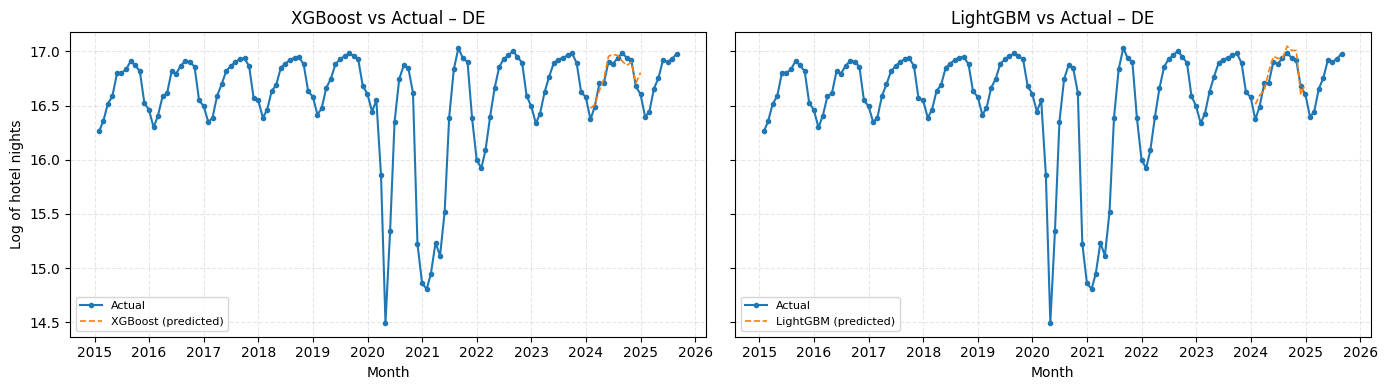

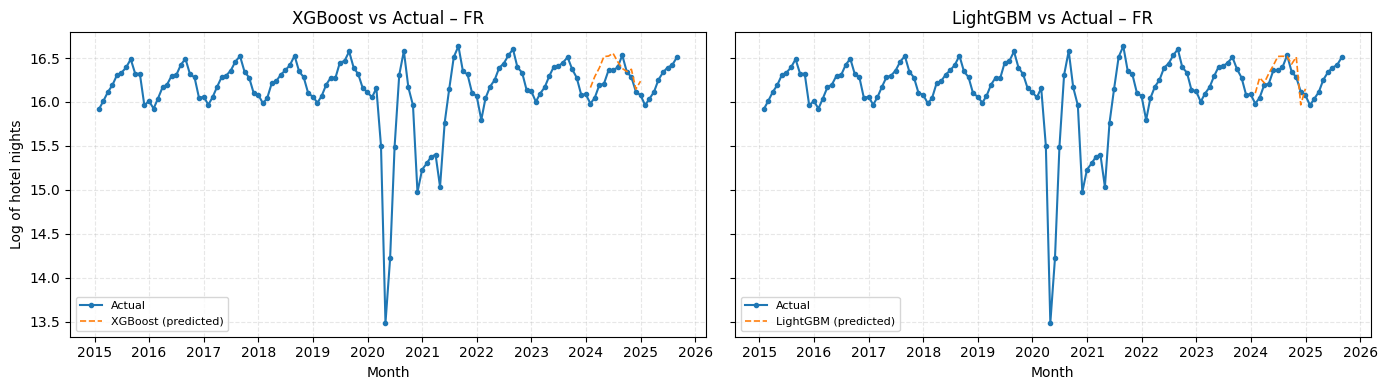

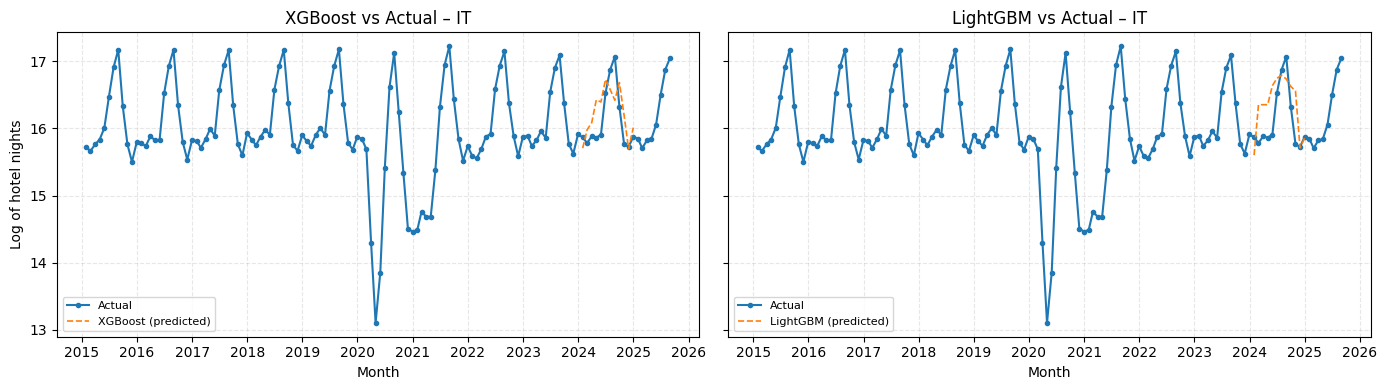

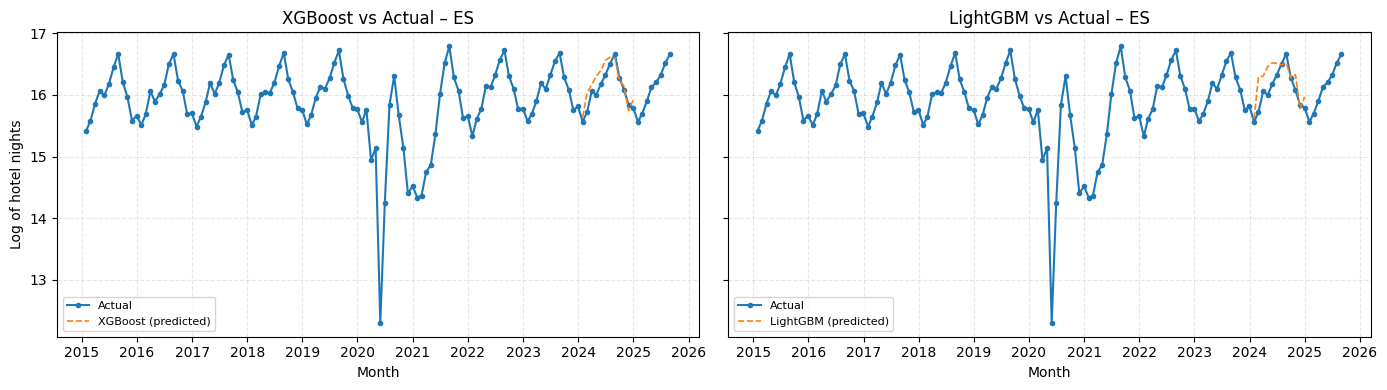

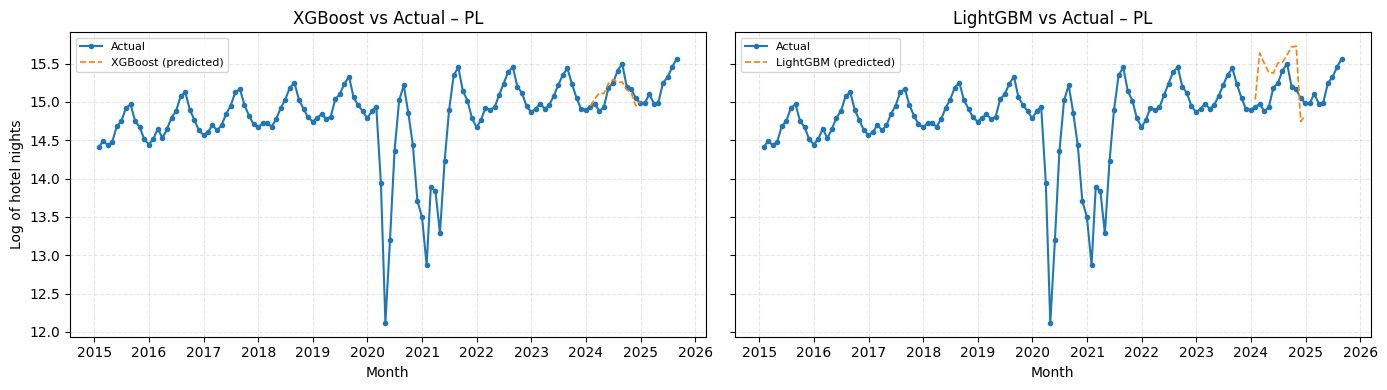

In [11]:
# %% -----------------------------------------------
# STEP 9 — VISUALIZE XGBOOST AND LIGHTGBM FORECASTS - TOP 5 COUNTRIES
# -----------------------------------------------

# --- Select top 5 countries dynamically ---
top_regions = (
    df.groupby("region")["log_nights_spent"]
    .mean()
    .nlargest(5)
    .index
)
print(f"[INFO] Plotting ML forecasts for: {list(top_regions)}")

# --- Use simple Matplotlib defaults (no seaborn overrides) ---
plt.rcdefaults()

for c in top_regions:
    subset = df.query("region == @c").sort_values("month")

    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)

    # --- Left: XGBoost ---
    axes[0].plot(
        subset["month"], subset["log_nights_spent"],
        label="Actual", marker="o", markersize=3, lw=1.5
    )
    if "yhat_xgb" in subset:
        axes[0].plot(
            subset["month"], subset["yhat_xgb"],
            label="XGBoost (predicted)", linestyle="--", lw=1.2
        )
    axes[0].set_title(f"XGBoost vs Actual – {c}")
    axes[0].set_xlabel("Month")
    axes[0].set_ylabel("Log of hotel nights")
    axes[0].legend(fontsize=8)
    axes[0].grid(alpha=0.3, linestyle="--")
    axes[0].xaxis.set_major_locator(mdates.YearLocator())
    axes[0].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    # --- Right: LightGBM ---
    axes[1].plot(
        subset["month"], subset["log_nights_spent"],
        label="Actual", marker="o", markersize=3, lw=1.5
    )
    if "yhat_lgbm" in subset:
        axes[1].plot(
            subset["month"], subset["yhat_lgbm"],
            label="LightGBM (predicted)", linestyle="--", lw=1.2
        )
    axes[1].set_title(f"LightGBM vs Actual – {c}")
    axes[1].set_xlabel("Month")
    axes[1].legend(fontsize=8)
    axes[1].grid(alpha=0.3, linestyle="--")
    axes[1].xaxis.set_major_locator(mdates.YearLocator())
    axes[1].xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

    plt.tight_layout()
    plt.show()

### 10. Machine Learning Models Evaluation and Save Predictions

In [12]:
# %% ===============================================================
# STEP 10 — MODEL EVALUATION & SAVE PREDICTIONS
# ===============================================================
# Purpose:
#   Evaluate XGBoost and LightGBM forecasts (RMSE/MAE) and save predictions.
# Outputs:
#   - hotel_predictions.csv (updated)
# ===============================================================

def rmse(y, yhat):
    return np.sqrt(mean_squared_error(y, yhat))

# --- Refresh valid subset with new predictions ---
valid = df[(df["month"] >= "2024-01-01") & (df["month"] < "2025-01-01")].copy()

# --- Ensure columns exist ---
missing_cols = [c for c in ["yhat_xgb", "yhat_lgbm"] if c not in valid.columns]
if missing_cols:
    print(f"⚠️ Missing columns in validation set: {missing_cols}")
else:
    print(f"[INFO] Validation subset ready with {len(valid)} rows.")

# --- Compute per-region metrics ---
eval_ml = (
    valid.groupby("region", group_keys=False)
    .apply(lambda d: pd.Series({
        "RMSE_XGB": rmse(d[target], d["yhat_xgb"]),
        "MAE_XGB": mean_absolute_error(d[target], d["yhat_xgb"]),
        "RMSE_LGBM": rmse(d[target], d["yhat_lgbm"]),
        "MAE_LGBM": mean_absolute_error(d[target], d["yhat_lgbm"]),
    }))
    .reset_index()
)

display(eval_ml.head())
print("\n📊 Mean RMSE / MAE across all regions:\n", eval_ml.mean(numeric_only=True).round(3))

# --- Save combined predictions ---
out_path = DATA_PROCESSED / "hotel_predictions.csv"
df.to_csv(out_path, index=False)
print(f"✅ Updated hotel_predictions.csv saved → {out_path.resolve()}")

[INFO] Validation subset ready with 312 rows.


,region,RMSE_XGB,MAE_XGB,RMSE_LGBM,MAE_LGBM
0,AT,0.149383,0.112739,0.250431,0.209017
1,BE,0.160732,0.145882,0.341768,0.294300
2,BG,0.315107,0.259209,0.454338,0.382115
3,CY,0.408533,0.348946,0.394860,0.328766
4,CZ,0.182443,0.147760,0.308100,0.250198



📊 Mean RMSE / MAE across all regions:
 RMSE_XGB     0.199
MAE_XGB      0.163
RMSE_LGBM    0.272
MAE_LGBM     0.226
dtype: float64
✅ Updated hotel_predictions.csv saved → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/data/processed/hotel_predictions.csv


### 11. Save Feature Matrix for SHAP Analyis

In [13]:
# %% -----------------------------------------------
# STEP 11 — SAVE FEATURE MATRIX FOR SHAP ANALYSIS
# Purpose: Export training feature matrix for interpretability in Notebook 4.
# Output: data/processed/train_features_for_shap.csv
# -----------------------------------------------

# --- Define path using global constant for clarity ---
FEATURE_PATH = DATA_PROCESSED / "train_features_for_shap.csv"

# --- Combine X_train and y_train for SHAP context ---
train_features = X_train.copy()
train_features["log_nights_spent"] = y_train

# --- Save to processed folder ---
train_features.to_csv(FEATURE_PATH, index=False)

# --- Confirmation ---
print(f"✅ Saved SHAP feature matrix → {FEATURE_PATH.resolve()}")
print(f"[INFO] Shape: {train_features.shape[0]} rows × {train_features.shape[1]} columns")

✅ Saved SHAP feature matrix → /Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/data/processed/train_features_for_shap.csv
[INFO] Shape: 2808 rows × 22 columns


### 12. Save Transformed SHAP Matrix (For XGB / LGBM)

In [14]:
# %% -----------------------------------------------
# STEP 12 — SAVE TRANSFORMED SHAP MATRIX (FOR XGB / LGBM)
# -----------------------------------------------
# Purpose:
#   Generate and save the final training matrix (after preprocessing)
#   used by XGBoost and LightGBM, with consistent feature names.
# Outputs:
#   - outputs/models/X_train_shap.parquet
#   - outputs/models/X_train_columns.json
# -----------------------------------------------

OUT_DIR = MODELS
OUT_DIR.mkdir(parents=True, exist_ok=True)

# --- Get the preprocessor from the XGBoost pipeline ---
preprocessor = pipe_xgb.named_steps["pre"]

# --- Transform training features ---
X_train_transformed = preprocessor.transform(X_train)

# --- Build correct feature names ---
cat_encoder = preprocessor.named_transformers_["cat"]
num_features = preprocessor.transformers_[1][2]  # columns passed to "num"

# Get categorical names
if hasattr(cat_encoder, "get_feature_names_out"):
    cat_features = cat_encoder.get_feature_names_out(["region"])
else:
    # Older sklearn fallback
    cat_features = cat_encoder.get_feature_names(["region"])

# Combine in same order as ColumnTransformer
feature_names = np.concatenate([cat_features, num_features])

# --- Sanity check for mismatches ---
if X_train_transformed.shape[1] != len(feature_names):
    print(f"⚠️ Feature count mismatch: transformed={X_train_transformed.shape[1]}, names={len(feature_names)}")
    print("🩹 Using generic names for safety.")
    feature_names = [f"feature_{i}" for i in range(X_train_transformed.shape[1])]

# --- Create named DataFrame ---
X_train_shap = pd.DataFrame(
    X_train_transformed,
    columns=feature_names,
    index=X_train.index
)

# --- Save artifacts ---
X_train_shap.to_parquet(OUT_DIR / "X_train_shap.parquet")
with open(OUT_DIR / "X_train_columns.json", "w") as f:
    json.dump(list(feature_names), f)

print(f"✅ SHAP matrix saved: {X_train_shap.shape[0]} rows × {X_train_shap.shape[1]} features")
print(f"📁 Saved to: {OUT_DIR / 'X_train_shap.parquet'}")

✅ SHAP matrix saved: 2808 rows × 46 features
📁 Saved to: ../outputs/models/X_train_shap.parquet


In [15]:
# %% -----------------------------------------------
# STEP 13 — SUMMARY AND HANDOFF
# -----------------------------------------------
# Notebook 3 completes the full modeling pipeline.
# Outputs include both econometric (ARIMAX, SARIMAX)
# and machine learning (XGB, LGBM) forecasts and model artifacts.

print("""
📘 Notebook 3 completed successfully.

Models estimated and saved:
→ Econometric: ARIMAX & SARIMAX (per region)
→ Machine Learning: XGBoost (global) and LightGBM (global + regional)
→ Predictions exported: ../data/processed/hotel_predictions.csv

Next step:
➡ Notebook 4 — Explainability and Economic Interpretation (SHAP + Panel Regressions)
""")


📘 Notebook 3 completed successfully.

Models estimated and saved:
→ Econometric: ARIMAX & SARIMAX (per region)
→ Machine Learning: XGBoost (global) and LightGBM (global + regional)
→ Predictions exported: ../data/processed/hotel_predictions.csv

Next step:
➡ Notebook 4 — Explainability and Economic Interpretation (SHAP + Panel Regressions)

